In [1]:
# import library and load dataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# load dataset
data_path = 'data/processed/data_for_preprocess.csv' 
data = pd.read_csv(data_path)


In [2]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   object 
 1   Application mode                                4424 non-null   object 
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   object 
 4   Daytime/evening attendance                      4424 non-null   object 
 5   Previous qualification                          4424 non-null   object 
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nationality                                     4424 non-null   object 
 8   Mother's qualification                          4424 non-null   object 
 9   Father's qualification                   

In [3]:
# Check for missing values
data.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [4]:
# Handled Missing value
# Qualification - Unknown
missing_mother_qualification = (data["Mother's qualification"]=='Unknown').sum()
missing_father_qualification = (data["Father's qualification"]=='Unknown').sum()

# Occupation - (blank)
missing_mother_occupation = (data["Mother's occupation"]=='(blank)').sum()
missing_father_occupation = (data["Father's occupation"]=='(blank)').sum()
print("Missing Value")
print(f"Mother's Qualification: {missing_mother_qualification}")
print(f"Father's Qualification: {missing_father_qualification}")
print(f"Mother's Occupation: {missing_mother_occupation}")
print(f"Father's Occupation: {missing_father_occupation}")

Missing Value
Mother's Qualification: 130
Father's Qualification: 112
Mother's Occupation: 17
Father's Occupation: 19


In [5]:
# Count the number of students for each nationality
nationality_counts = data['Nationality'].value_counts().sort_index()

# Display the counts
print("Number of students per nationality:")
print(nationality_counts)

# print International students count
print("International", data['International'].value_counts())

Number of students per nationality:
Nationality
Angolan                     2
Brazilian                  38
Cape Verdean               13
Colombian                   1
Cuban                       1
Dutch                       1
English                     1
German                      2
Guinean                     5
Italian                     3
Lithuanian                  1
Mexican                     2
Moldova (Republic of)       3
Mozambican                  2
Portuguese               4314
Romanian                    2
Russian                     2
Santomean                  14
Spanish                    13
Turkish                     1
Ukrainian                   3
Name: count, dtype: int64
International International
no     4314
yes     110
Name: count, dtype: int64


In [6]:
# Feature Extraction

# Change Nationality -> Speaks Portuguese

# List of Portuguese-speaking countries
portuguese_speaking_countries = ['Portuguese', 'Brazilian', 'Angolan', 'Cape Verdean', 'Guinean', 'Mozambican', 'Santomean']

# Create a new column 'Speaks_Portuguese'
data['Speaks_Portuguese'] = data['Nationality'].apply(lambda x: 'yes' if x in portuguese_speaking_countries else 'no')

# Drop 'Nacionality' column
data.drop(columns=['Nationality'], inplace=True)

# Count the number who don't speak portuguese
non_speaker = (data["Speaks_Portuguese"]=='no').sum()
print(non_speaker)

36


In [7]:
# Data Transformation

X = data.drop('Target', axis=1)
y = data['Target']

# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Normalize numerical features
scaler = StandardScaler() 
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_data = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
encoded_data.columns = encoder.get_feature_names_out(categorical_cols)

# Combine the data
X = X.drop(categorical_cols, axis=1)
X = pd.concat([X, encoded_data], axis=1)

# Transform target variable
y = (y != 'Dropout').astype(int) # 0 if 'Dropout', 1 otherwise

In [8]:
# Feature information after transformation
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Columns: 236 entries, Application order to Speaks_Portuguese_yes
dtypes: float64(236)
memory usage: 8.0 MB


In [9]:
# Target information after transformation
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4424 entries, 0 to 4423
Series name: Target
Non-Null Count  Dtype
--------------  -----
4424 non-null   int64
dtypes: int64(1)
memory usage: 34.7 KB


In [10]:
# Target distribution
value_percentages = y.value_counts(normalize=True) * 100
print(value_percentages)

Target
1    67.879747
0    32.120253
Name: proportion, dtype: float64


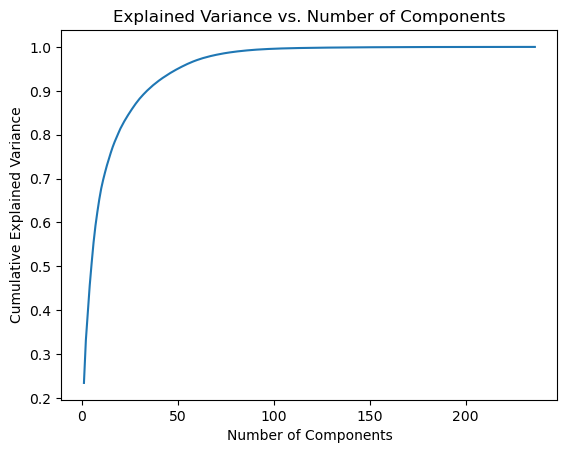

Selected number of components: 50
Cumulative explained variance for first 50 components: 0.95


In [12]:
# Step 1: Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Step 2: Plot explained variance to determine the number of components to keep
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Step 3: Choose k components that explain, e.g., 95% variance
k = 0
for i, cumulative in enumerate(cumulative_variance):
    if cumulative >= 0.95:  # 95% explained variance threshold
        k = i + 1
        break

# Step 4: Apply PCA with k components
pca = PCA(n_components=k)
X_reduced = pca.fit_transform(X)

print(f"Selected number of components: {k}")
print(f"Cumulative explained variance for first {k} components: {cumulative_variance[k-1]:.2f}")


In [20]:
print(f'Size before PCA: {X.shape}')
print(f'Size after PCA: {X_reduced.shape}')

Size before PCA: (4424, 236)
Size after PCA: (4424, 50)
